# MNIST

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import *
import scipy

%matplotlib inline

/Users/abulbasar/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/abulbasar/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/abulbasar/anaconda/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be remove

### Dataset description

Datasource: http://yann.lecun.com/exdb/mnist/

The training dataset consists of 60,000 training digits and the test set contains 10,000 samples, respectively. The images in the MNIST dataset consist of  pixels, and each pixel is represented by a gray scale intensity value. Here, we unroll the  pixels into 1D row vectors, which represent the rows in our image array (784 per row or image). The second array (labels) returned by the load_mnist function contains the corresponding target variable, the class labels (integers 0-9) of the handwritten digits.


Csv version of the files are available in the following links.
CSV training set http://www.pjreddie.com/media/files/mnist_train.csv
CSV test set http://www.pjreddie.com/media/files/mnist_test.csv


In [2]:
training = pd.read_csv("/data/MNIST/mnist_train.csv", header = None)
testing = pd.read_csv("/data/MNIST/mnist_test.csv", header = None)

In [3]:
X_train, y_train = training.iloc[:, 1:].values, training.iloc[:, 0].values 
X_test, y_test = testing.iloc[:, 1:].values, testing.iloc[:, 0].values 

In [4]:
print("Shape of X_train: ", X_train.shape, "shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape, "shape of y_test: ", y_test.shape)

Shape of X_train:  (60000, 784) shape of y_train:  (60000,)
Shape of X_test:  (10000, 784) shape of y_test:  (10000,)


### Distribution of class frequencies

Text(0,0.5,'Frequency (normed)')

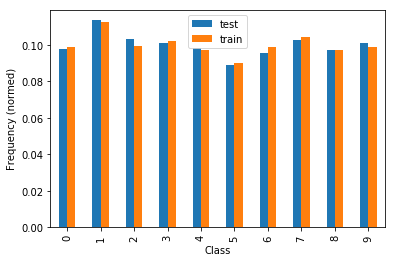

In [5]:
label_counts = pd.DataFrame({
    "train": pd.Series(y_train).value_counts().sort_index(), 
    "test": pd.Series(y_test).value_counts().sort_index()
})
(label_counts / label_counts.sum()).plot.bar()

plt.xlabel("Class")
plt.ylabel("Frequency (normed)")

### Chisquare test on class frequencies

In [6]:
scipy.stats.chisquare(label_counts.train, label_counts.test)

Power_divergenceResult(statistic=250122.18994735854, pvalue=0.0)

### Display a few sample images

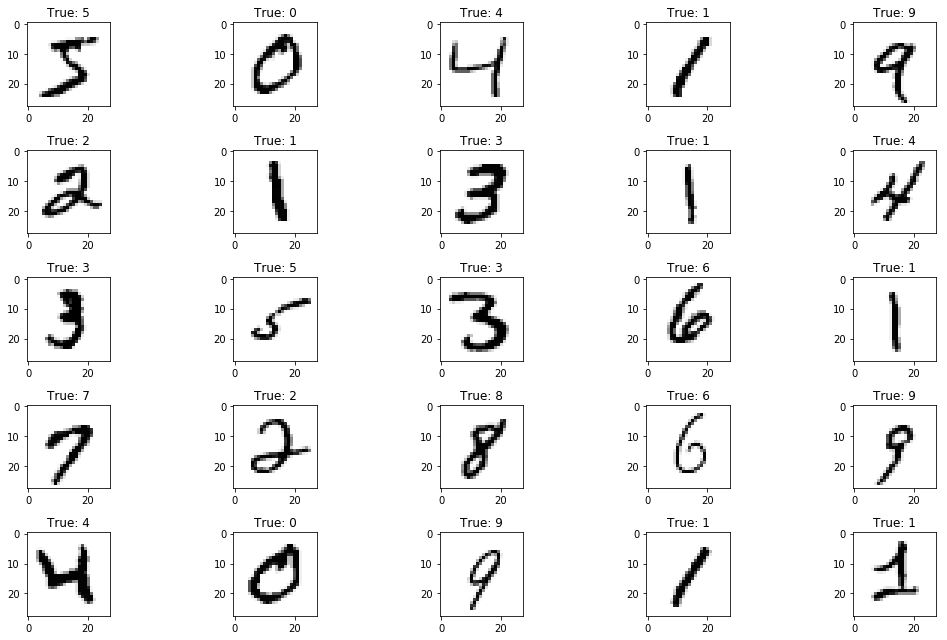

In [7]:
fig, axes = plt.subplots(5, 5, figsize = (15, 9))
for i, ax in enumerate(fig.axes):
    img = X_train[i, :].reshape(28, 28)
    ax.imshow(img, cmap = "Greys", interpolation="nearest")
    ax.set_title("True: %i" % y_train[i])
plt.tight_layout()

### View different variations of a digit

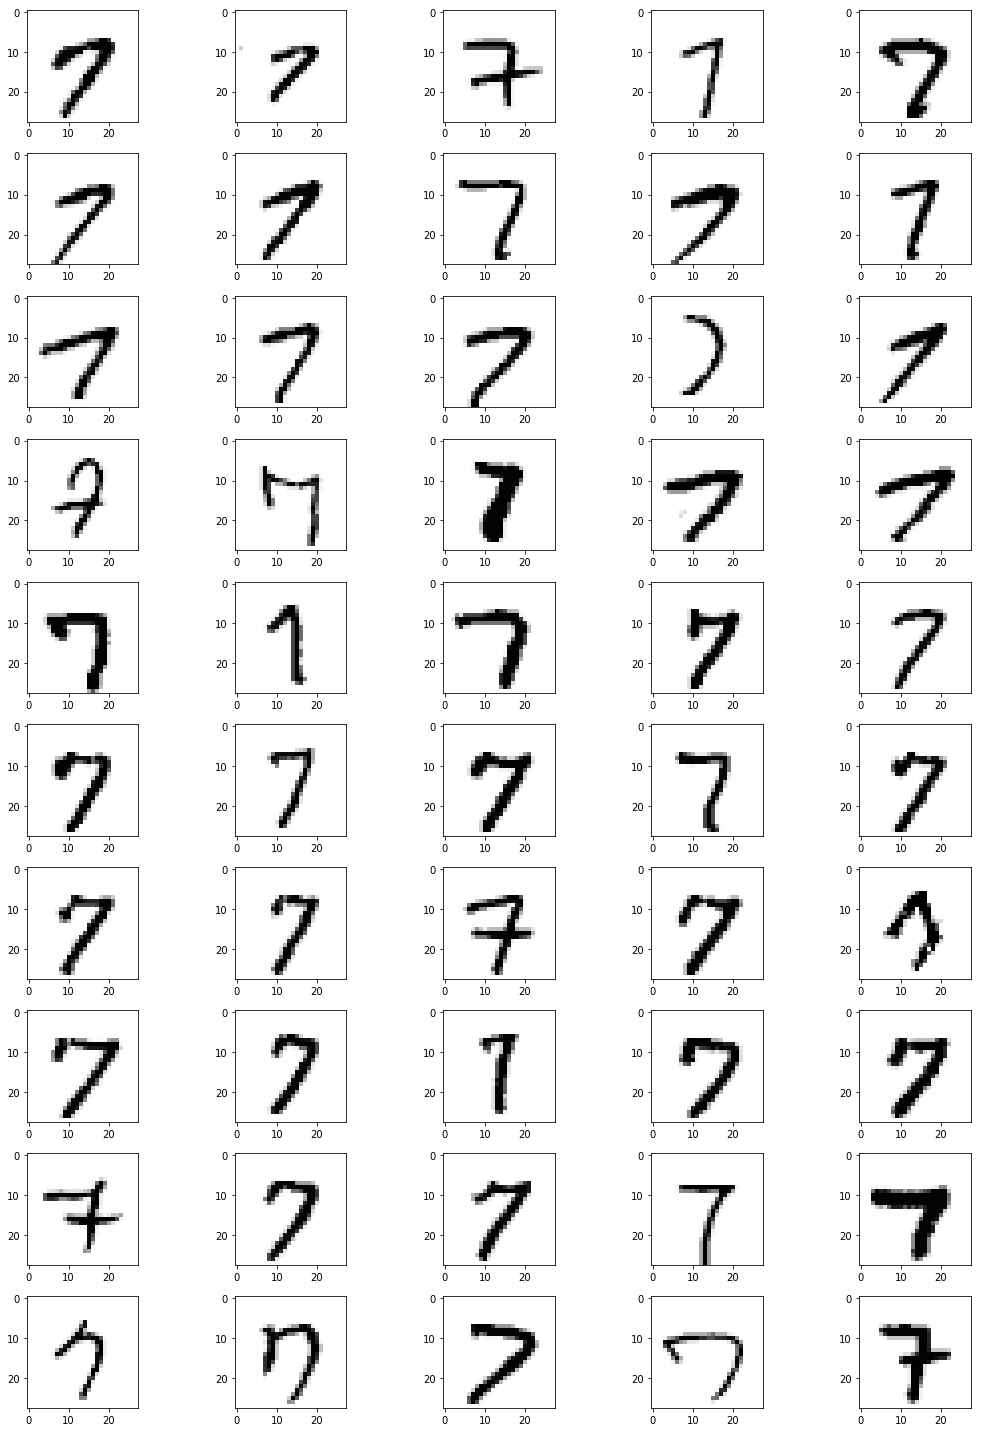

In [8]:
fig, axes = plt.subplots(10, 5, figsize = (15, 20))

for i, ax in enumerate(fig.axes):
    img = X_train[y_train == 7][i, :].reshape(28, 28)
    ax.imshow(img, cmap = "Greys", interpolation="nearest")

plt.tight_layout()

### Feature scaling

In [9]:
scaler = preprocessing.StandardScaler()
X_train_std = scaler.fit_transform(X_train.astype(np.float64))
X_test_std = scaler.transform(X_test.astype(np.float64))

### Applying logistic regression classifier

In [10]:
%%time 
lr = linear_model.LogisticRegression()
lr.fit(X_train_std, y_train)
print("accuracy:", lr.score(X_test_std, y_test))

accuracy: 0.9171
CPU times: user 11min 50s, sys: 1.38 s, total: 11min 52s
Wall time: 11min 52s


### Display wrong predictions

No of miss:  829


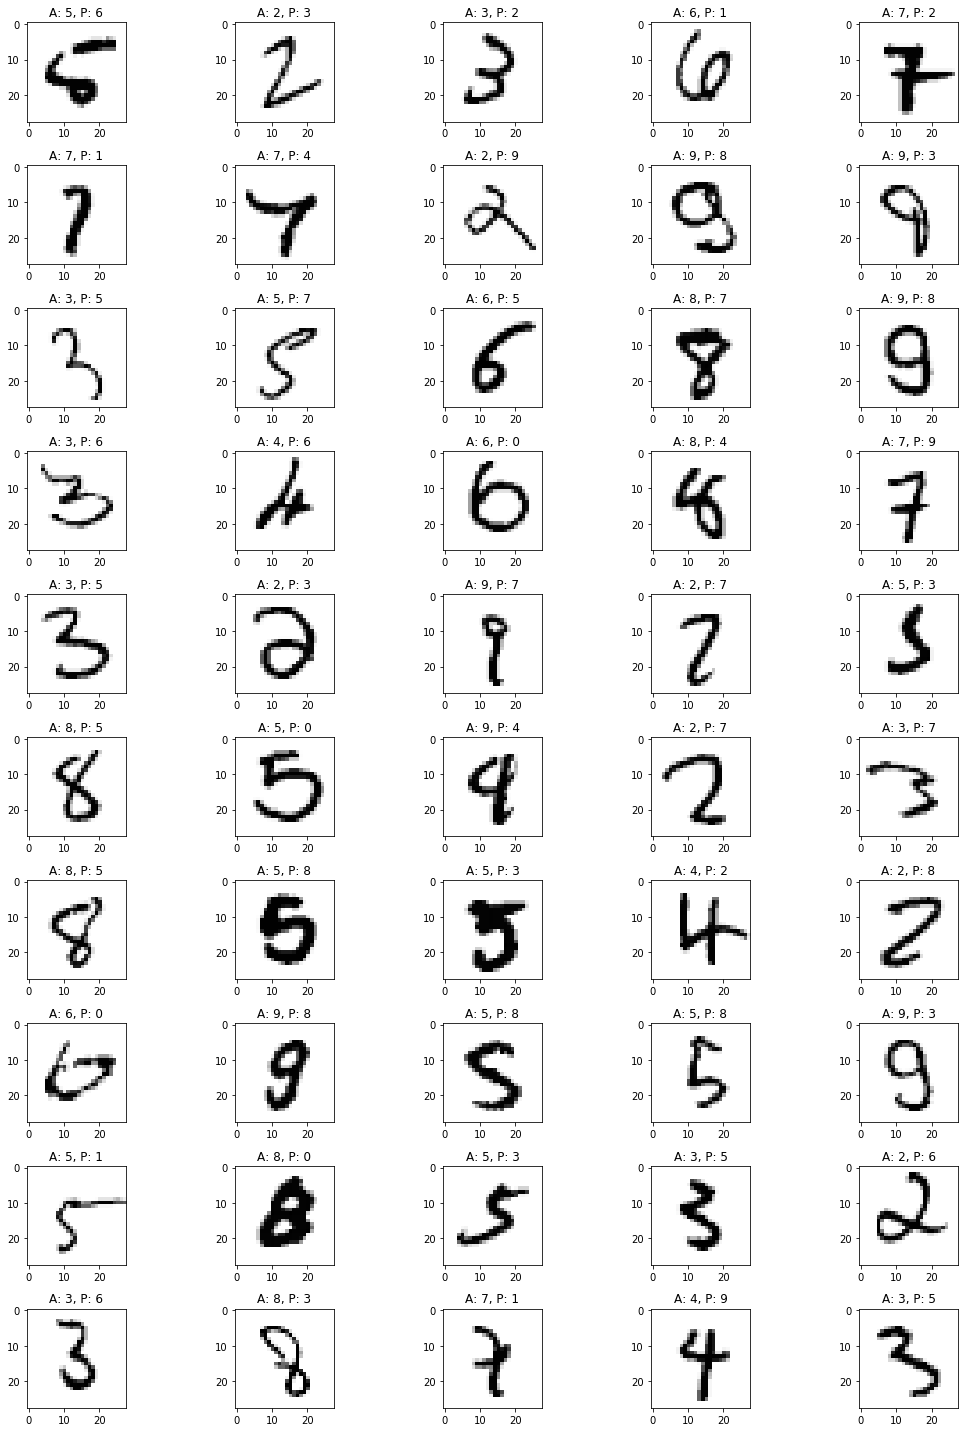

In [11]:
y_test_pred = lr.predict(X_test_std)
miss_indices = (y_test != y_test_pred)
misses = X_test[miss_indices]
print("No of miss: ", misses.shape[0])

fig, axes = plt.subplots(10, 5, figsize = (15, 20))
misses_actual = y_test[miss_indices]
misses_pred = y_test_pred[miss_indices]

for i, ax in enumerate(fig.axes):
    img = misses[i].reshape(28, 28)
    ax.imshow(img, cmap = "Greys", interpolation="nearest")
    ax.set_title("A: %s, P: %d" % (misses_actual[i], misses_pred[i]))
plt.tight_layout()

### Applying SGD classifier

In [12]:
inits = np.random.randn(10, 784) 
inits = inits / np.std(inits, axis=1).reshape(10, -1)

In [13]:
%%time
est = linear_model.SGDClassifier(n_jobs=4, tol=1e-5, eta0 = 0.15,  
                                 learning_rate = "invscaling", 
                                 alpha = 0.01, max_iter= 100)
est.fit(X_train_std, y_train, inits)
print("accuracy", est.score(X_test_std, y_test), "iterations:", est.n_iter_)

accuracy 0.9209 iterations: 47
CPU times: user 27.4 s, sys: 215 ms, total: 27.7 s
Wall time: 8.83 s


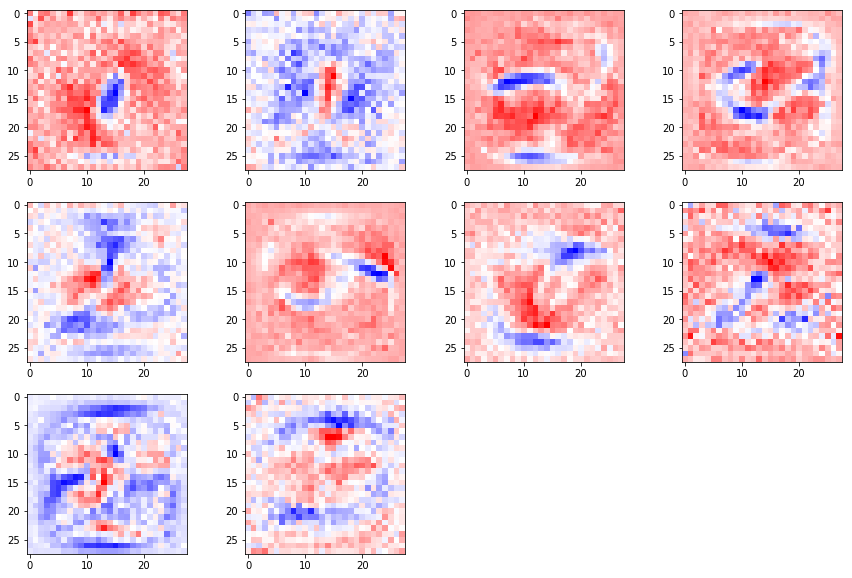

In [14]:
fig, _ = plt.subplots(3, 4, figsize = (15, 10))
for i, ax in enumerate(fig.axes):
    if i < est.coef_.shape[0]:
        ax.imshow(est.coef_[i, :].reshape(28, 28), cmap = "bwr", interpolation="nearest")
    else:
        ax.remove()

In [15]:
pd.DataFrame(est.coef_[0, :].reshape(28, 28))

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.041340,-0.083744,0.038232,0.053368,-0.014164,-0.061339,-0.027433,0.109623,-0.026222,-0.051522,...,0.101004,0.041945,-0.002550,0.025023,-0.036319,0.078118,0.063360,-0.014658,-0.048840,0.044466
1,-0.117511,-0.042890,0.088114,-0.027449,0.025384,-0.047334,-0.018449,0.022574,-0.077487,-0.060981,...,0.015102,-0.065140,-0.010722,-0.049677,-0.082337,0.033339,-0.047543,0.046065,0.016769,0.029798
2,0.091572,-0.059533,-0.024205,0.006171,-0.005878,0.002353,-0.008457,0.008194,0.002065,-0.052933,...,-0.037495,-0.069780,-0.064653,0.020324,-0.033194,-0.025839,-0.068084,-0.062893,-0.018241,0.004692
3,0.012284,-0.045563,0.011654,-0.010694,-0.008686,-0.015523,0.001384,-0.023454,-0.027425,-0.021806,...,-0.077167,-0.063370,-0.036756,-0.036734,-0.074055,0.020572,-0.016257,0.015561,-0.076205,-0.001953
4,0.038190,-0.006219,-0.036261,-0.012859,-0.036171,0.004289,-0.046565,-0.031924,0.029226,0.020840,...,0.001075,0.008170,-0.046674,-0.020232,0.005725,0.020468,-0.022378,-0.029770,-0.022984,-0.061402
5,0.049574,0.103457,-0.032148,0.013034,-0.007324,-0.029559,0.008342,-0.011768,-0.064231,-0.022532,...,0.008047,-0.011131,-0.019173,-0.003936,-0.010410,-0.006540,-0.023155,-0.057363,-0.065610,-0.003050
6,-0.023145,-0.039034,-0.067422,-0.006177,-0.088349,-0.013815,0.014393,-0.006159,-0.056585,-0.020034,...,0.019738,0.033669,-0.042502,0.050040,-0.012148,-0.002805,-0.050735,-0.061722,-0.001923,-0.022114
7,-0.044615,0.001412,-0.006821,-0.112434,-0.009049,-0.019319,-0.079954,-0.029177,-0.073609,-0.039095,...,0.094172,0.081164,0.005558,-0.031875,0.036838,0.032705,-0.055898,-0.137616,0.006162,-0.004332
8,0.058085,-0.038200,-0.015800,0.001676,-0.087808,0.021727,0.032674,-0.023458,-0.029830,0.031890,...,0.035671,0.024223,0.047641,-0.001858,0.063487,-0.024790,-0.002694,-0.109103,-0.095116,-0.054177
9,0.038191,0.022911,-0.033741,-0.012586,-0.025735,-0.023013,-0.094430,-0.014168,-0.026361,-0.053779,...,0.116554,0.085581,0.065359,0.010903,-0.003346,0.030327,-0.065173,-0.049949,-0.014860,-0.007009
